In [1]:
using Revise
using Pkg
TAMBO_PATH = "/Users/jlazar/research/TAMBO-MC/Tambo/"
Pkg.activate(TAMBO_PATH)
using Tambo
using CSV
using StatsBase
using Distributions
using JLD2
using Plots

include("../figures/paperstyle.jl")

  Activating project at `~/research/TAMBO-MC/Tambo`


no_bg_dark! (generic function with 1 method)

In [7]:
# const zmin = -1100units.m
# const zmax = 1100units.m
upgoing_sim = jldopen("/Users/jlazar/Downloads/Oct16th2023_WhitePaper_300k.jld2")
downgoing_sim = jldopen("/Users/jlazar/Downloads/Feb1st2024_downgoing_500k.jld2")
lowe_sim = jldopen("/Users/jlazar/Downloads/Feb2nd2024_lowE_100k.jld2")
config = SimulationConfig(tambo_coordinates=whitepaper_coord, θmax=π/2)
geo = Tambo.Geometry(config)
plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
injector = Tambo.Injector(config)

DATA_DIR = "./output/"

"./output/"

In [8]:
altmin = 1.8925255158436627units.km
altmax = 4.092525515843662units.km

2.0739818168780746e10

In [9]:
ℓ = 1000 * units.m
Δs = 150 * units.m
modules = Tambo.make_detector_array(
    whitepaper_coord,
    ℓ,
    Δs,
    altmin,
    altmax,
    plane,
    geo
)
# modules = Tambo.make_trianglearray(-2000units.m, 3000units.m, -ℓ / 2, ℓ / 2, Δs, ϕ=whitepaper_normal_vec.ϕ)
# modules = filter((m,) -> zmin < Tambo.plane_z(m.x, m.y, plane) < zmax, modules);

200-element Vector{Tambo.SquareDetectionModule}:
 Tambo.SquareDetectionModule([-7.280097596362571e9, 2.6348275742431107e9, 5.233771406024351e9], [0.6320560935396677 -0.5118285336590905 -0.5818390213381704; 0.6293200947742926 0.7771462013760829 0.0; 0.4521739852453368 -0.3661629880519191 0.8133039734614851], [9.50199550764375e6, 4.054184749928e6, 152031.92812229999], 1)
 Tambo.SquareDetectionModule([-7.106036893755536e9, 3.34097226216458e9, 5.454916676701436e9], [0.6320560935396677 -0.5118285336590905 -0.5818390213381704; 0.6293200947742926 0.7771462013760829 0.0; 0.4521739852453368 -0.3661629880519191 0.8133039734614851], [9.50199550764375e6, 4.054184749928e6, 152031.92812229999], 2)
 Tambo.SquareDetectionModule([-6.451512658237081e9, 3.658045555885043e9, 5.233771406024351e9], [0.6320560935396677 -0.5118285336590905 -0.5818390213381704; 0.6293200947742926 0.7771462013760829 0.0; 0.4521739852453368 -0.3661629880519191 0.8133039734614851], [9.50199550764375e6, 4.054184749928e6, 152031.92

In [10]:
downgoing_event_dicts = jldopen("$(DATA_DIR)/20240201_event_dicts_merged.jld2")
upgoing_event_dicts = jldopen("$(DATA_DIR)/20231231_event_dicts_merged.jld2")
lowe_event_dicts = jldopen("$(DATA_DIR)/20240202_event_dicts_merged.jld2")

JLDFile /Users/jlazar/research/TAMBO-MC/notebooks/output/20240202_event_dicts_merged.jld2 (read-only)
 └─📂 20240202
    └─📂 1000_150
       ├─🔢 338
       ├─🔢 1947
       ├─🔢 3338
       ├─🔢 4563
       ├─🔢 5825
       ├─🔢 7516
       ├─🔢 8791
       └─ ⋯ (3397 more entries)

In [11]:
function event_weight(event::Tambo.CorsikaEvent, seed::Int)
    Random.seed!(seed)
    weight = event.weight
    if weight > 1 # This is a weighted particle and needs to be sampled
        weight = rand(Poisson(weight))
    end
    return Int(weight)
end

function event_weight(event::Tambo.CorsikaEvent)
    event_weight(event, 215)
end

event_weight (generic function with 2 methods)

In [12]:
function compute_n_hits(hits_dict::Dict{Int, Vector{Tambo.CorsikaEvent}})
    n = 0
    for (_, v) in hits_dict
        n += sum(event_weight.(v))
    end
    return n
end

compute_n_hits (generic function with 1 method)

In [13]:
function has_triggered(
    hits_dict::Dict{Int, Vector{Tambo.CorsikaEvent}};
    local_threshhold=3,
    global_threshhold=30,
    sensor_threshold=3
)
    nhits = 0
    nsensors = 0
    for events in values(hits_dict)
        weights = event_weight.(events)
        
        if sum(weights) < local_threshhold
            continue
        end
        
        nsensors += 1
        nhits += sum(weights)
        if nhits >= global_threshhold && nsensors >= sensor_threshold
            return true
        end
    end

    return false
end

has_triggered (generic function with 1 method)

In [14]:
γ = 2.37
norm = 1.44e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
pl = Tambo.PowerLaw(γ, 100units.GeV, 1e9units.GeV, norm)

PowerLaw(γ=2.37, emin=100.0 GeV, emax=1.0e9 GeV)

In [15]:
proposal_events = downgoing_sim["proposal_events"]

try
    did_cross_rock
catch
    global did_cross_rock = fill(false, length(proposal_events))

    for (idx, event) in enumerate(proposal_events)
        if ~Tambo.check_passed_through_rock(event, plane, geo)
            continue
        end
        did_cross_rock[idx] = true
    end
end;

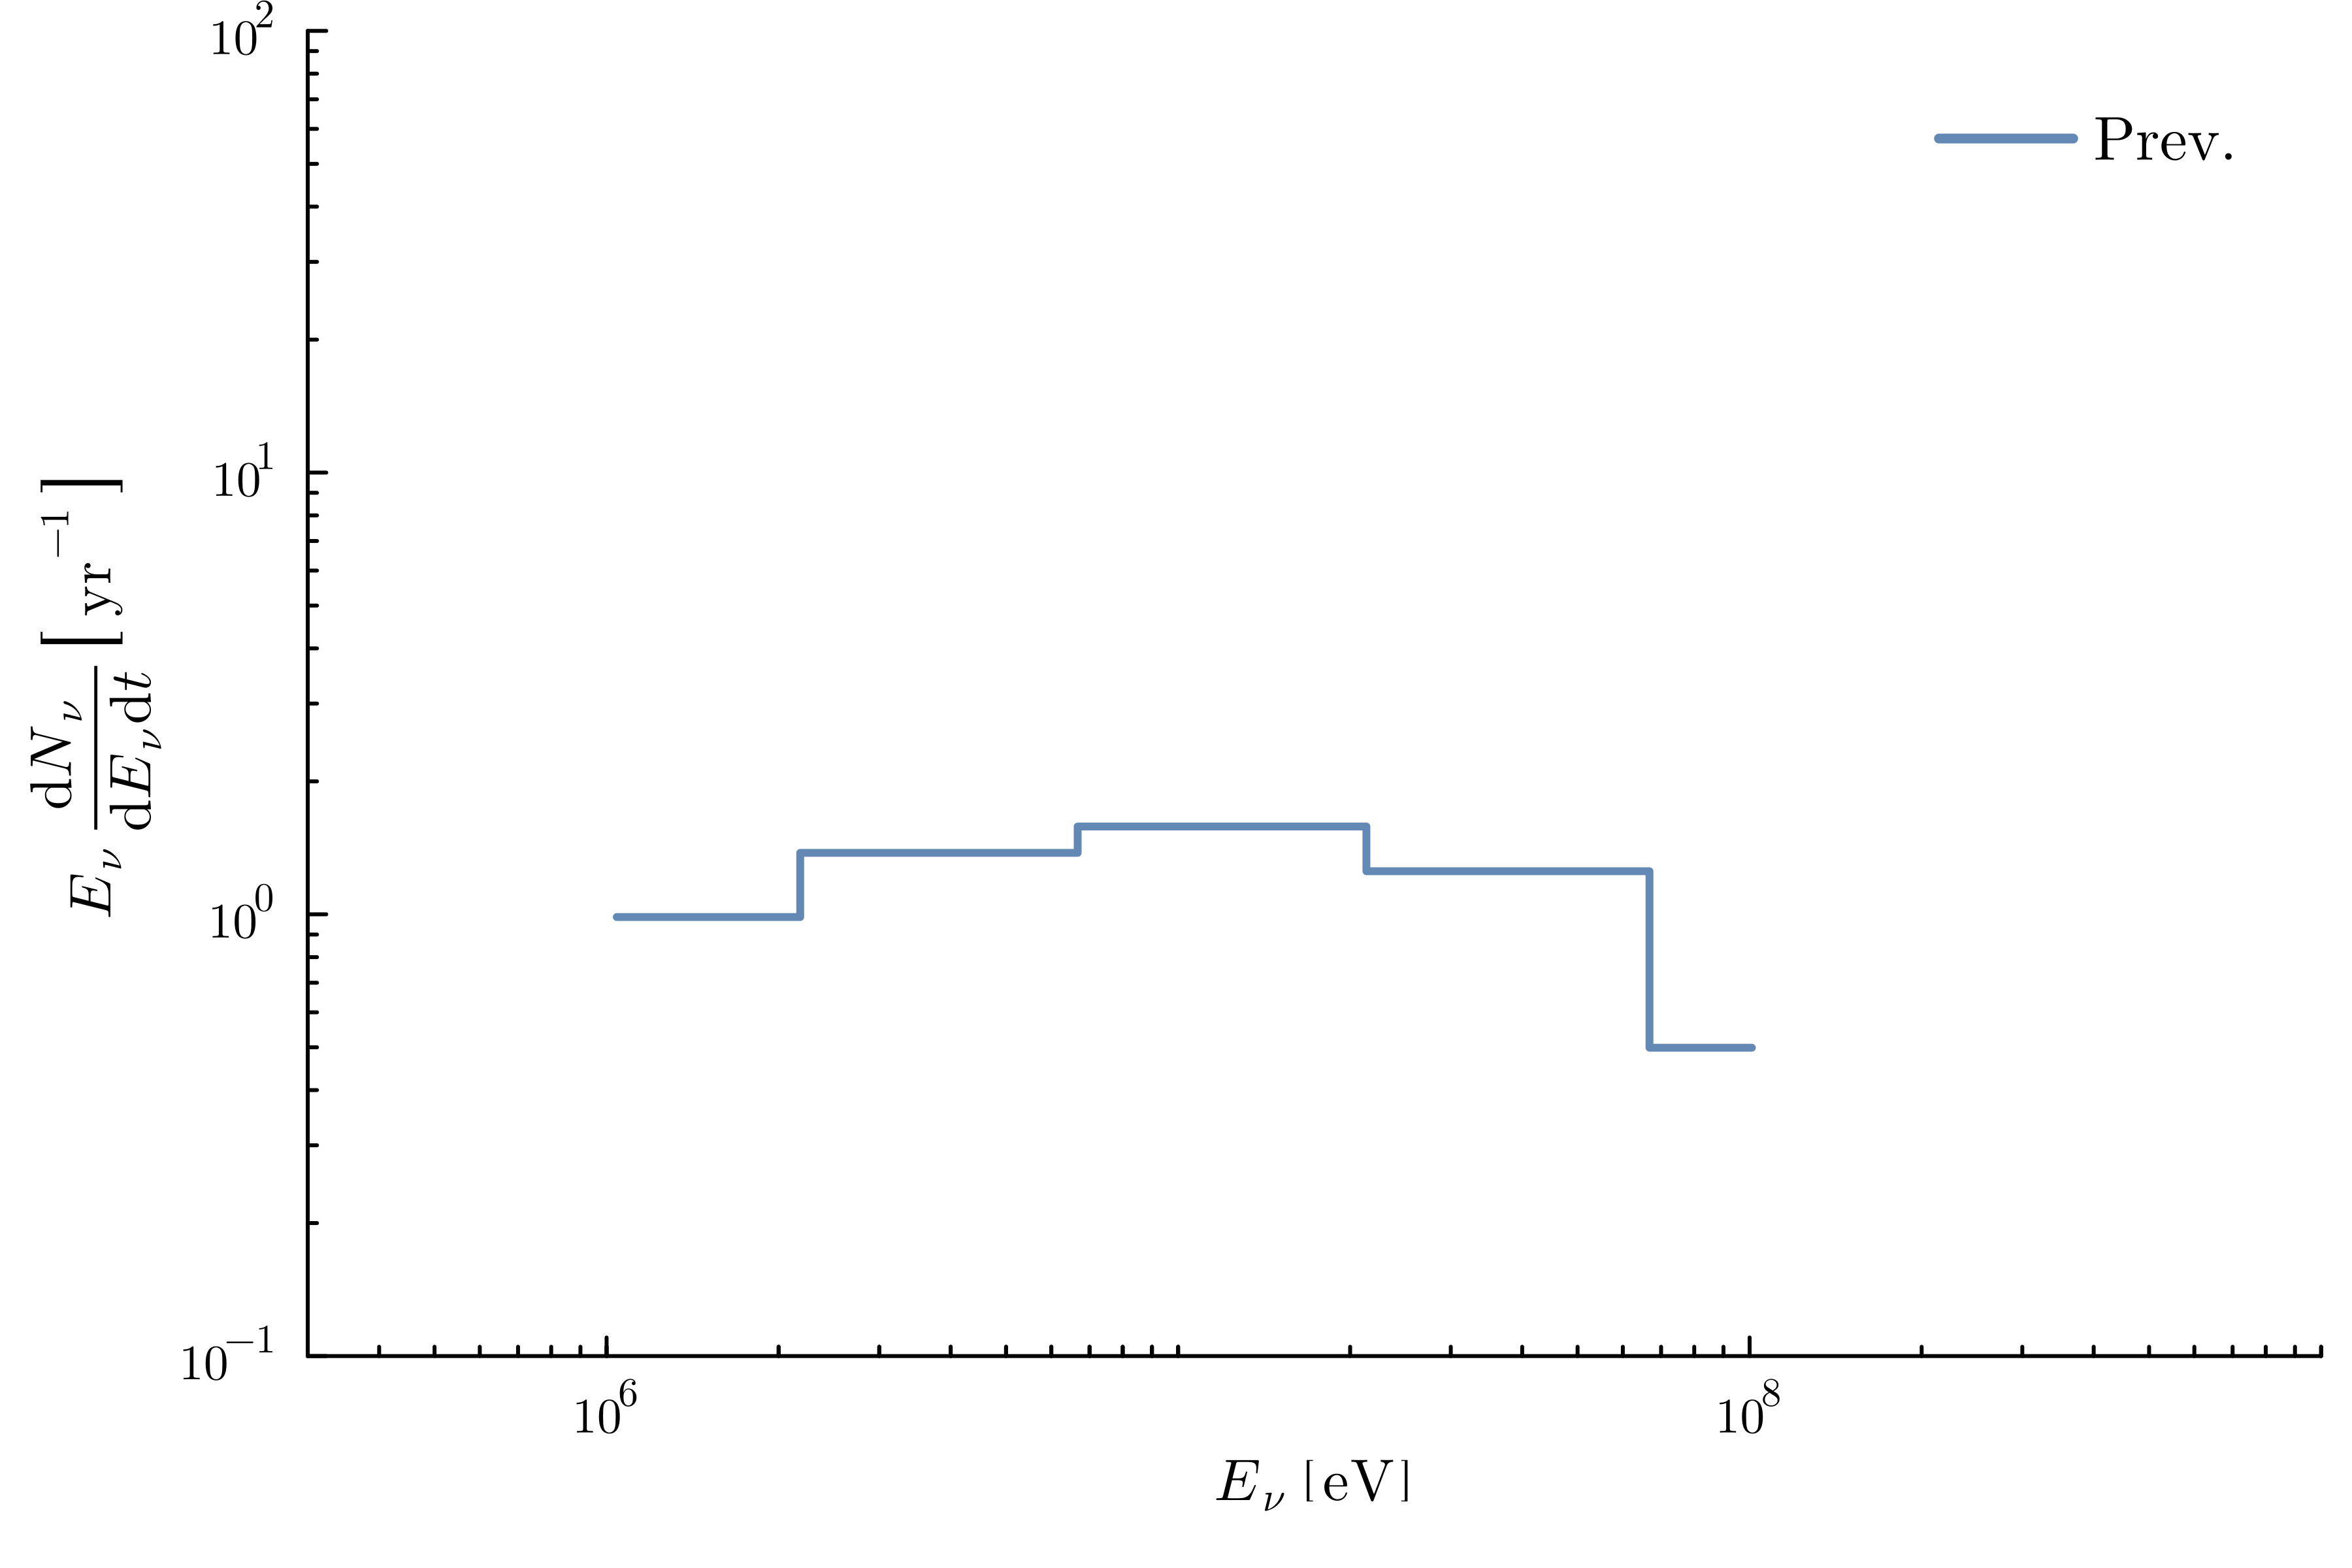

In [23]:
# area_previous_calc = 429units.km^2
previous_calc = CSV.File("/Users/jlazar/Downloads/Default Dataset.csv")
digitized_prev_calc_centers = getindex.(previous_calc, 1) * units.GeV
digitized_prev_calc_rates = getindex.(previous_calc, 2) / 3

inferred_prev_calc_edges = 10 .^ (14.681:0.5:17.181)
inferred_prev_calc_cents = (inferred_prev_calc_edges[2:end] + inferred_prev_calc_edges[1:end-1]) / 2

inferred_prev_calc_widths = inferred_prev_calc_edges[2:end] - inferred_prev_calc_edges[1:end-1]

plt = plot(
    xscale=:log,
    yscale=:log,
    xlabel=L"E_{\nu}~\left[\mathrm{eV}\right]",
    ylabel=L"E_{\nu}\frac{\mathrm{d}N_{\nu}}{\mathrm{d}E_{\nu}\mathrm{d}t}~\left[\mathrm{yr}^{-1}\right]",
    bottommargin=3mm,
    leftmargin=3mm,
    xlimits=(3e5, 1e9),
    ylimits=(1e-1, 100),
    size=(600, 400)
    
)
plot!(
    plt,
    digitized_prev_calc_centers / units.GeV,
    inferred_prev_calc_cents .* digitized_prev_calc_rates ./ inferred_prev_calc_widths,
    label="Prev.",
    linetype=:stepmid,
)
display(plt)

length(triggered_weights) = 478
length(triggered_weights) = 697
length(triggered_weights) = 39


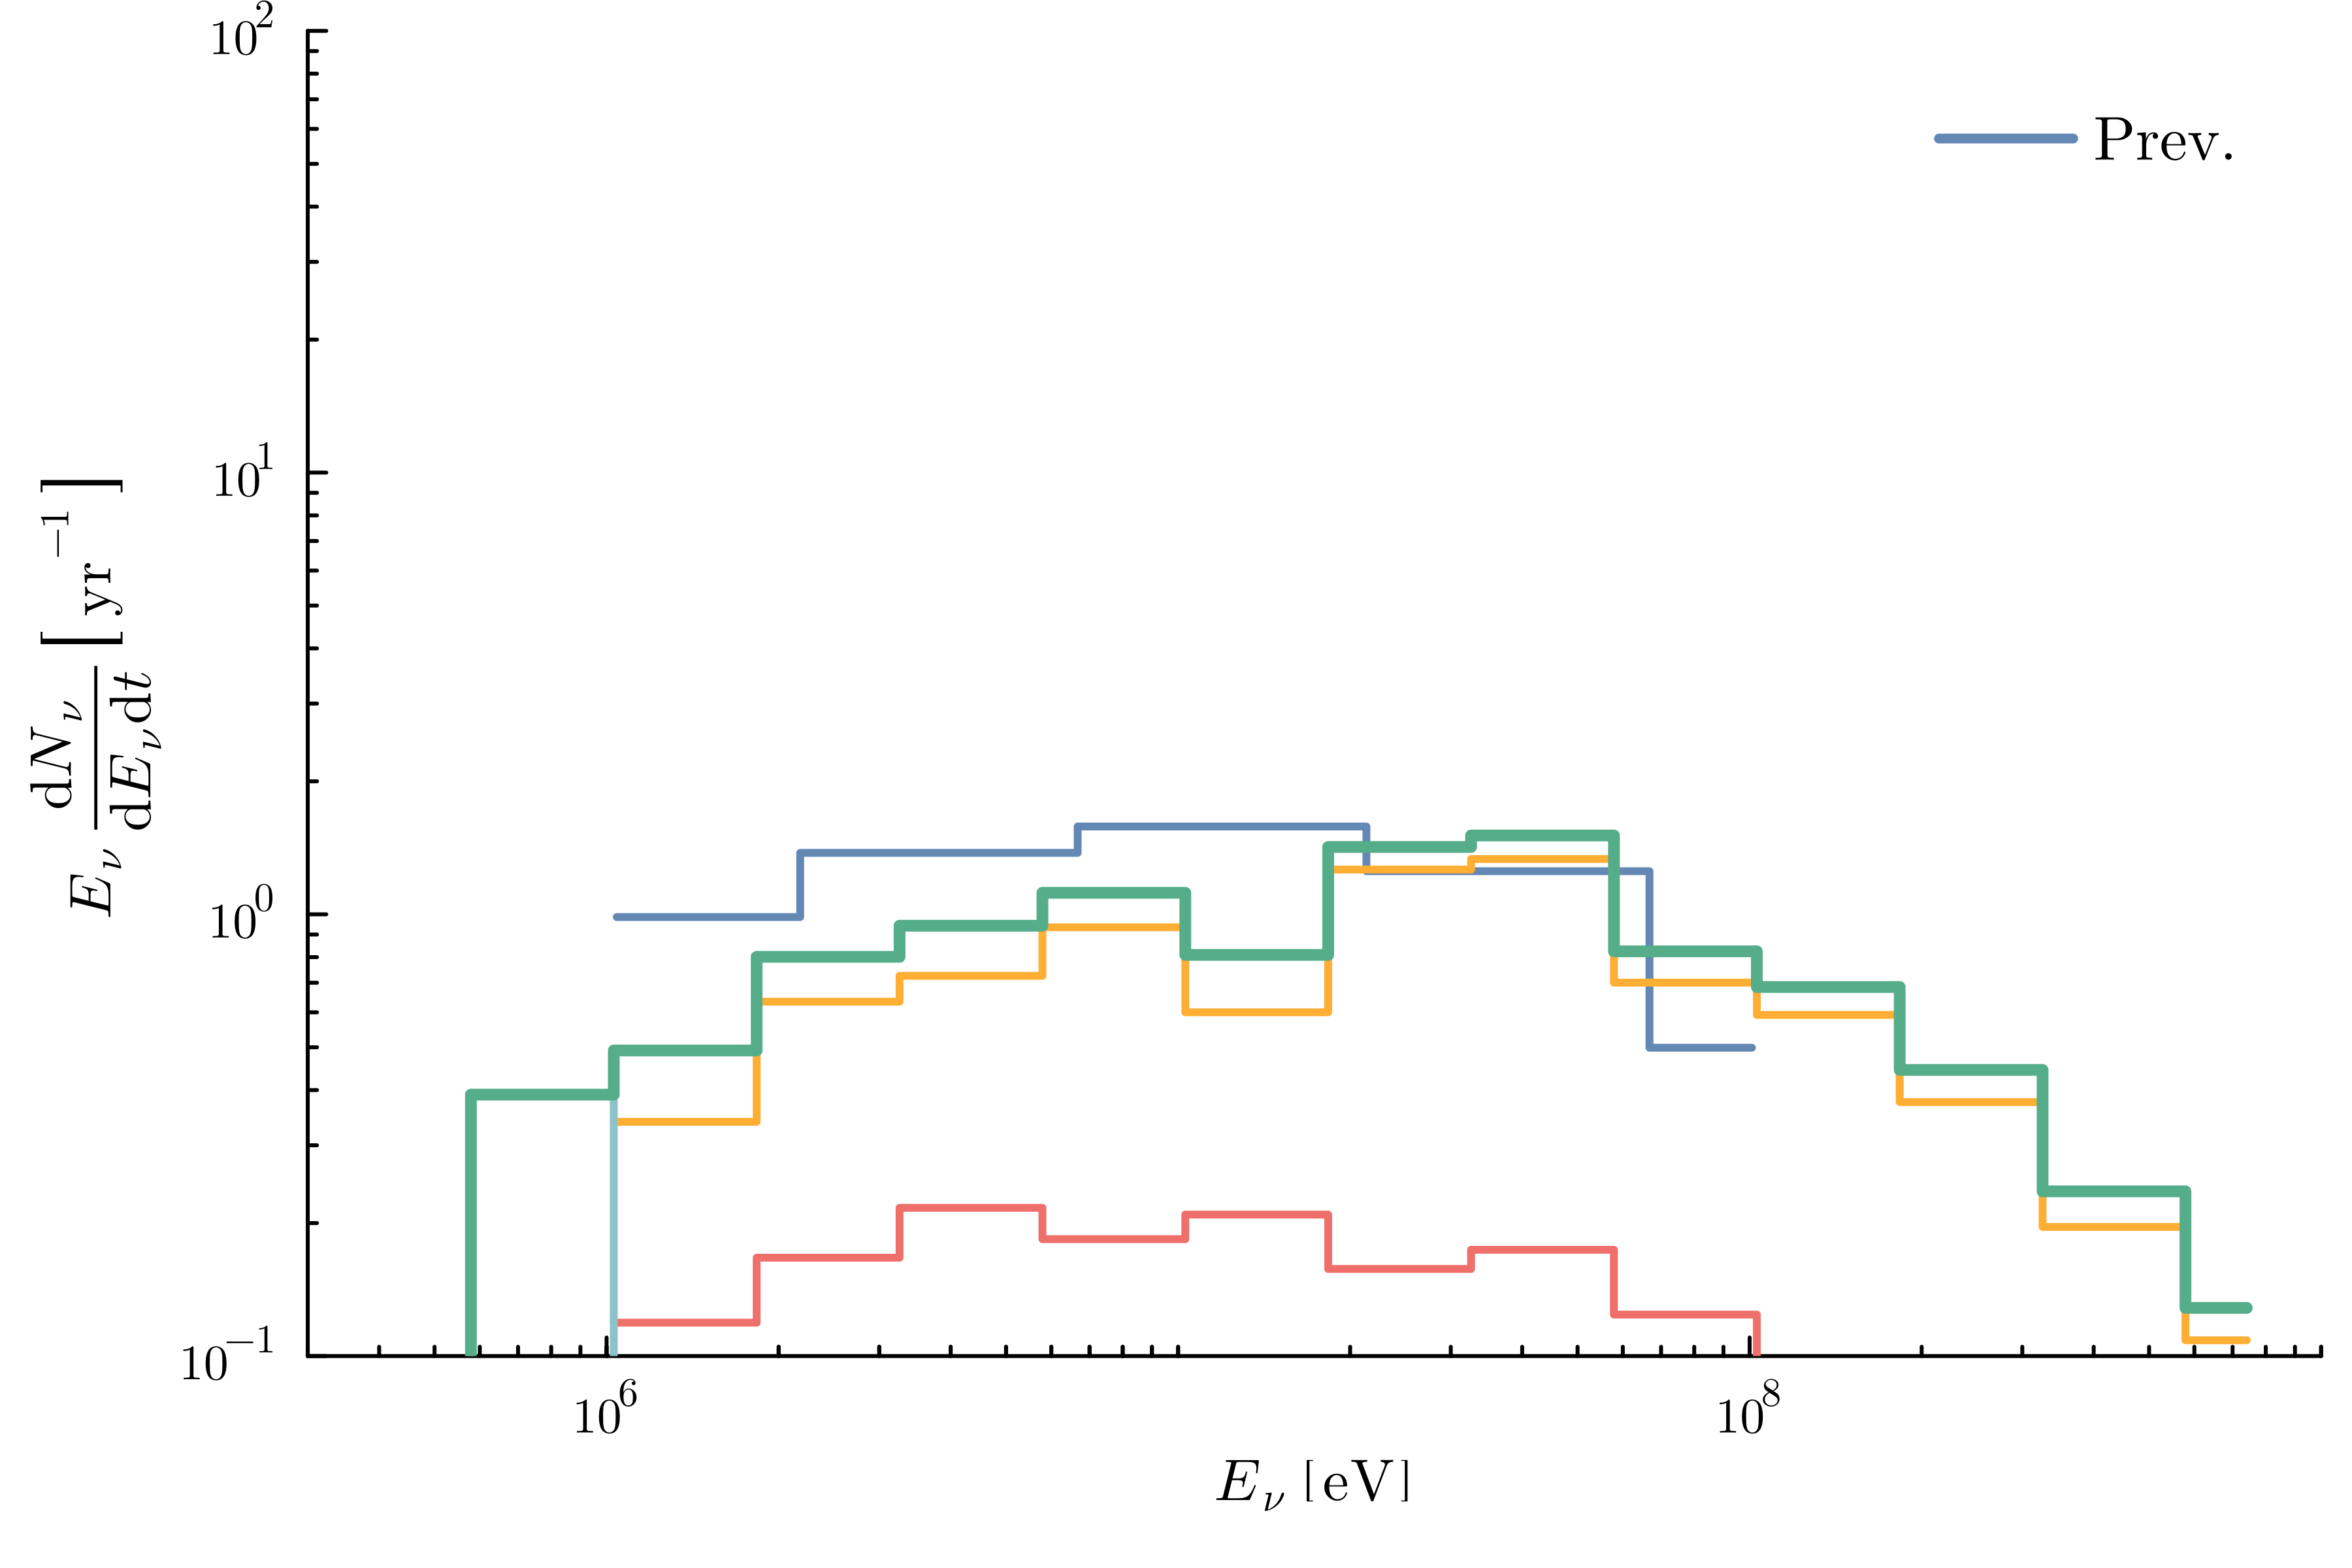

In [24]:
edges = 10 .^ (log(10, 3e14):0.25:18)
cents = (edges[1:end-1] + edges[2:end]) / 2
widths = edges[2:end] - edges[1:end-1]

sims = [
    upgoing_sim,
    downgoing_sim,
    lowe_sim
]
gps = [
    upgoing_event_dicts["20231231/1000_150"],
    downgoing_event_dicts["20240201/1000_150"],
    lowe_event_dicts["20240202/1000_150"]
] 

out = zeros(length(cents))

for (idx, (gp, sim)) in enumerate(zip(gps, sims))
    using Random
    Random.seed!(343)

    triggered_event_numbers = Int[]

    for key in keys(gp)
        # Extremely jank to remove events that don't cross rock
        if idx==2 && ~(parse(Int, key) in findall(did_cross_rock))
            continue
        end
        if ~has_triggered(gp[key])
            continue
        end
        push!(triggered_event_numbers, parse(Int, key))
    end
    sort!(triggered_event_numbers)
    # global triggered_event_numbers
    # @show length(triggered_event_numbers)
    # println(sort(triggered_event_numbers))
    # break
    
    
    config = SimulationConfig(; filter(x->x[1]!=:geo_spline_path, sim["config"])...)
    geo = Tambo.Geometry(config)
    plane = Tambo.Plane(whitepaper_normal_vec, whitepaper_coord, geo)
    injector = Tambo.Injector(config)
    
    injected_events = sim["injected_events"]
    triggered_events = injected_events[triggered_event_numbers];
    # injected_weights = Tambo.oneweight.(
    #     injected_events,
    #     Ref(injector.xs),
    #     Ref(injector.xs),
    #     Ref(injector.powerlaw),
    #     Ref(injector.anglesampler),
    #     Ref(injector.injectionvolume),
    #     Ref(geo)
    # ) / length(injected_events)
    # injected_fluxes = pl.(injected_events["initial_state"]["energy"])

    triggered_weights = Tambo.oneweight.(
        triggered_events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    ) / maximum(triggered_event_numbers)
    @show length(triggered_weights)
    triggered_fluxes = pl.(triggered_events["initial_state"]["energy"]);
    
    h = fit(
        Histogram,
        triggered_events["initial_state"]["energy"],
        Weights(triggered_weights .* triggered_fluxes),
        edges
    )
    plot!(
        plt, 
        cents ./ units.GeV,
        h.weights .* cents ./ widths .* units.second * 10^7.5 .* (22_000 / 164),
        # h.weights .* cents ./ widths .* units.second * 10^7.5 .* (22_000 / length(modules)),
        linetype=:stepmid
    )
    out .+= h.weights
end
plot!(
    plt, 
    cents ./ units.GeV,
    out .* cents ./ widths .* units.second * 10^7.5 .* (22_000 / 164),
    # out .* cents ./ widths .* units.second * 10^7.5 .* (22_000 / length(modules)),
    linetype=:stepmid, lw=3
)

display(plt)

In [23]:
function widths_cents(bins)
    widths = bins[2:end] .- bins[1:end-1]
    cents = (bins[2:end] .+ bins[1:end-1]) / 2
    return widths, cents
end

widths_cents (generic function with 1 method)

In [24]:
energy_bins = 10 .^ (log(10, 300units.TeV):0.33333:log(10, 1e9units.GeV))
energy_widths, energy_cents = widths_cents(energy_bins)
hit_bins = 10 .^ LinRange(log(10, 30), 5.75, 18)
hit_widths, hit_cents = widths_cents(hit_bins)
plt = plot()

out = zeros((length(energy_bins) - 1, length(hit_bins) - 1))

nhit_min = Inf
nhit_max = 0

for (idx, (emin, emax)) in enumerate(zip(energy_bins, energy_bins[2:end]))
    n_hits_list = []
    println((emin, emax))
    for (sim, event_dict) in zip(sims, gps)
        for key in keys(event_dict)
            
            event = sim["injected_events"][parse(Int, key)]
            if ~(emin < event.initial_state.energy && event.initial_state.energy < emax)
                continue
            end
            
            if ~has_triggered(event_dict[key])
                continue
            end
            
            n_hits = compute_n_hits(event_dict[key])
            nhit_max = maximum([n_hits, nhit_max])
            nhit_min = minimum([n_hits, nhit_min])
            push!(n_hits_list, n_hits)
            
        end
    end
    h = fit(Histogram, n_hits_list, hit_bins)
    out[idx, :] .= h.weights
    # plot!(plt, hit_bins[2:end], h.weights, linetype=:steppre)
end
# display(plt)

(2.999999999999989e14, 6.463254462593994e14)
(6.463254462593994e14, 1.3924552749413778e15)
(1.3924552749413778e15, 2.9999309232424805e15)
(2.9999309232424805e15, 6.463105642373585e15)
(6.463105642373585e15, 1.392423212842916e16)
(1.392423212842916e16, 2.9998618480754924e16)
(2.9998618480754924e16, 6.462956825579821e16)
(6.462956825579821e16, 1.3923911514827083e17)
(1.3923911514827083e17, 2.9997927744990125e17)
(2.9997927744990125e17, 6.462808012212678e17)


In [88]:
out./ sum(out, dims=2)

10×17 Matrix{Float64}:
 0.142857   0.428571   0.285714  0.0        …  0.0         0.0  0.0
 0.176471   0.294118   0.294118  0.0980392     0.0         0.0  0.0
 0.101695   0.237288   0.355932  0.135593      0.0         0.0  0.0
 0.0957447  0.212766   0.180851  0.12766       0.0         0.0  0.0
 0.0686275  0.137255   0.245098  0.156863      0.0         0.0  0.0
 0.119048   0.150794   0.238095  0.0714286  …  0.0         0.0  0.0
 0.11875    0.1875     0.175     0.0875        0.0         0.0  0.0
 0.118012   0.161491   0.124224  0.136646      0.0         0.0  0.0
 0.0913978  0.11828    0.193548  0.11828       0.00537634  0.0  0.00537634
 0.0538922  0.0958084  0.149701  0.155689      0.011976    0.0  0.0

In [89]:
log.(10, transpose(out./ sum(out, dims=2)) ./ hit_widths)


17×10 Matrix{Float64}:
  -2.21642   -2.12465   -2.36403  …   -2.2994    -2.41039   -2.6398
  -1.99065   -2.15415   -2.2474       -2.41452   -2.54976   -2.64127
  -2.41809   -2.4055    -2.32265      -2.77981   -2.58723   -2.69879
 -Inf        -3.13396   -2.99313      -2.98977   -3.05245   -2.93311
  -3.22181   -3.30613   -3.36941      -3.32826   -3.3038    -3.36898
 -Inf        -4.33562   -3.92179  …   -3.72094   -3.51736   -3.5955
 -Inf       -Inf        -4.65025      -4.00705   -4.19467   -3.898
 -Inf       -Inf       -Inf           -4.38333   -4.35887   -4.35346
 -Inf       -Inf       -Inf           -4.50974   -5.04955   -4.60481
 -Inf       -Inf       -Inf           -5.84026   -5.05785   -4.95306
 -Inf       -Inf       -Inf       …   -5.31346   -5.37615   -5.50544
 -Inf       -Inf       -Inf           -5.86583   -5.92852   -5.88172
 -Inf       -Inf       -Inf          -Inf       -Inf        -6.13307
 -Inf       -Inf       -Inf          -Inf        -6.90833  -Inf
 -Inf       -Inf    

In [90]:
energy_cents ./ units.GeV

10-element Vector{Float64}:
 473162.7231296991
      1.0193903606003885e6
      2.196193099091929e6
      4.731518282808033e6
      1.0193668885401372e7
      2.196142530459204e7
      4.7314093368276566e7
      1.0193434170203453e8
      2.1960919629908603e8
      4.731300393355845e8

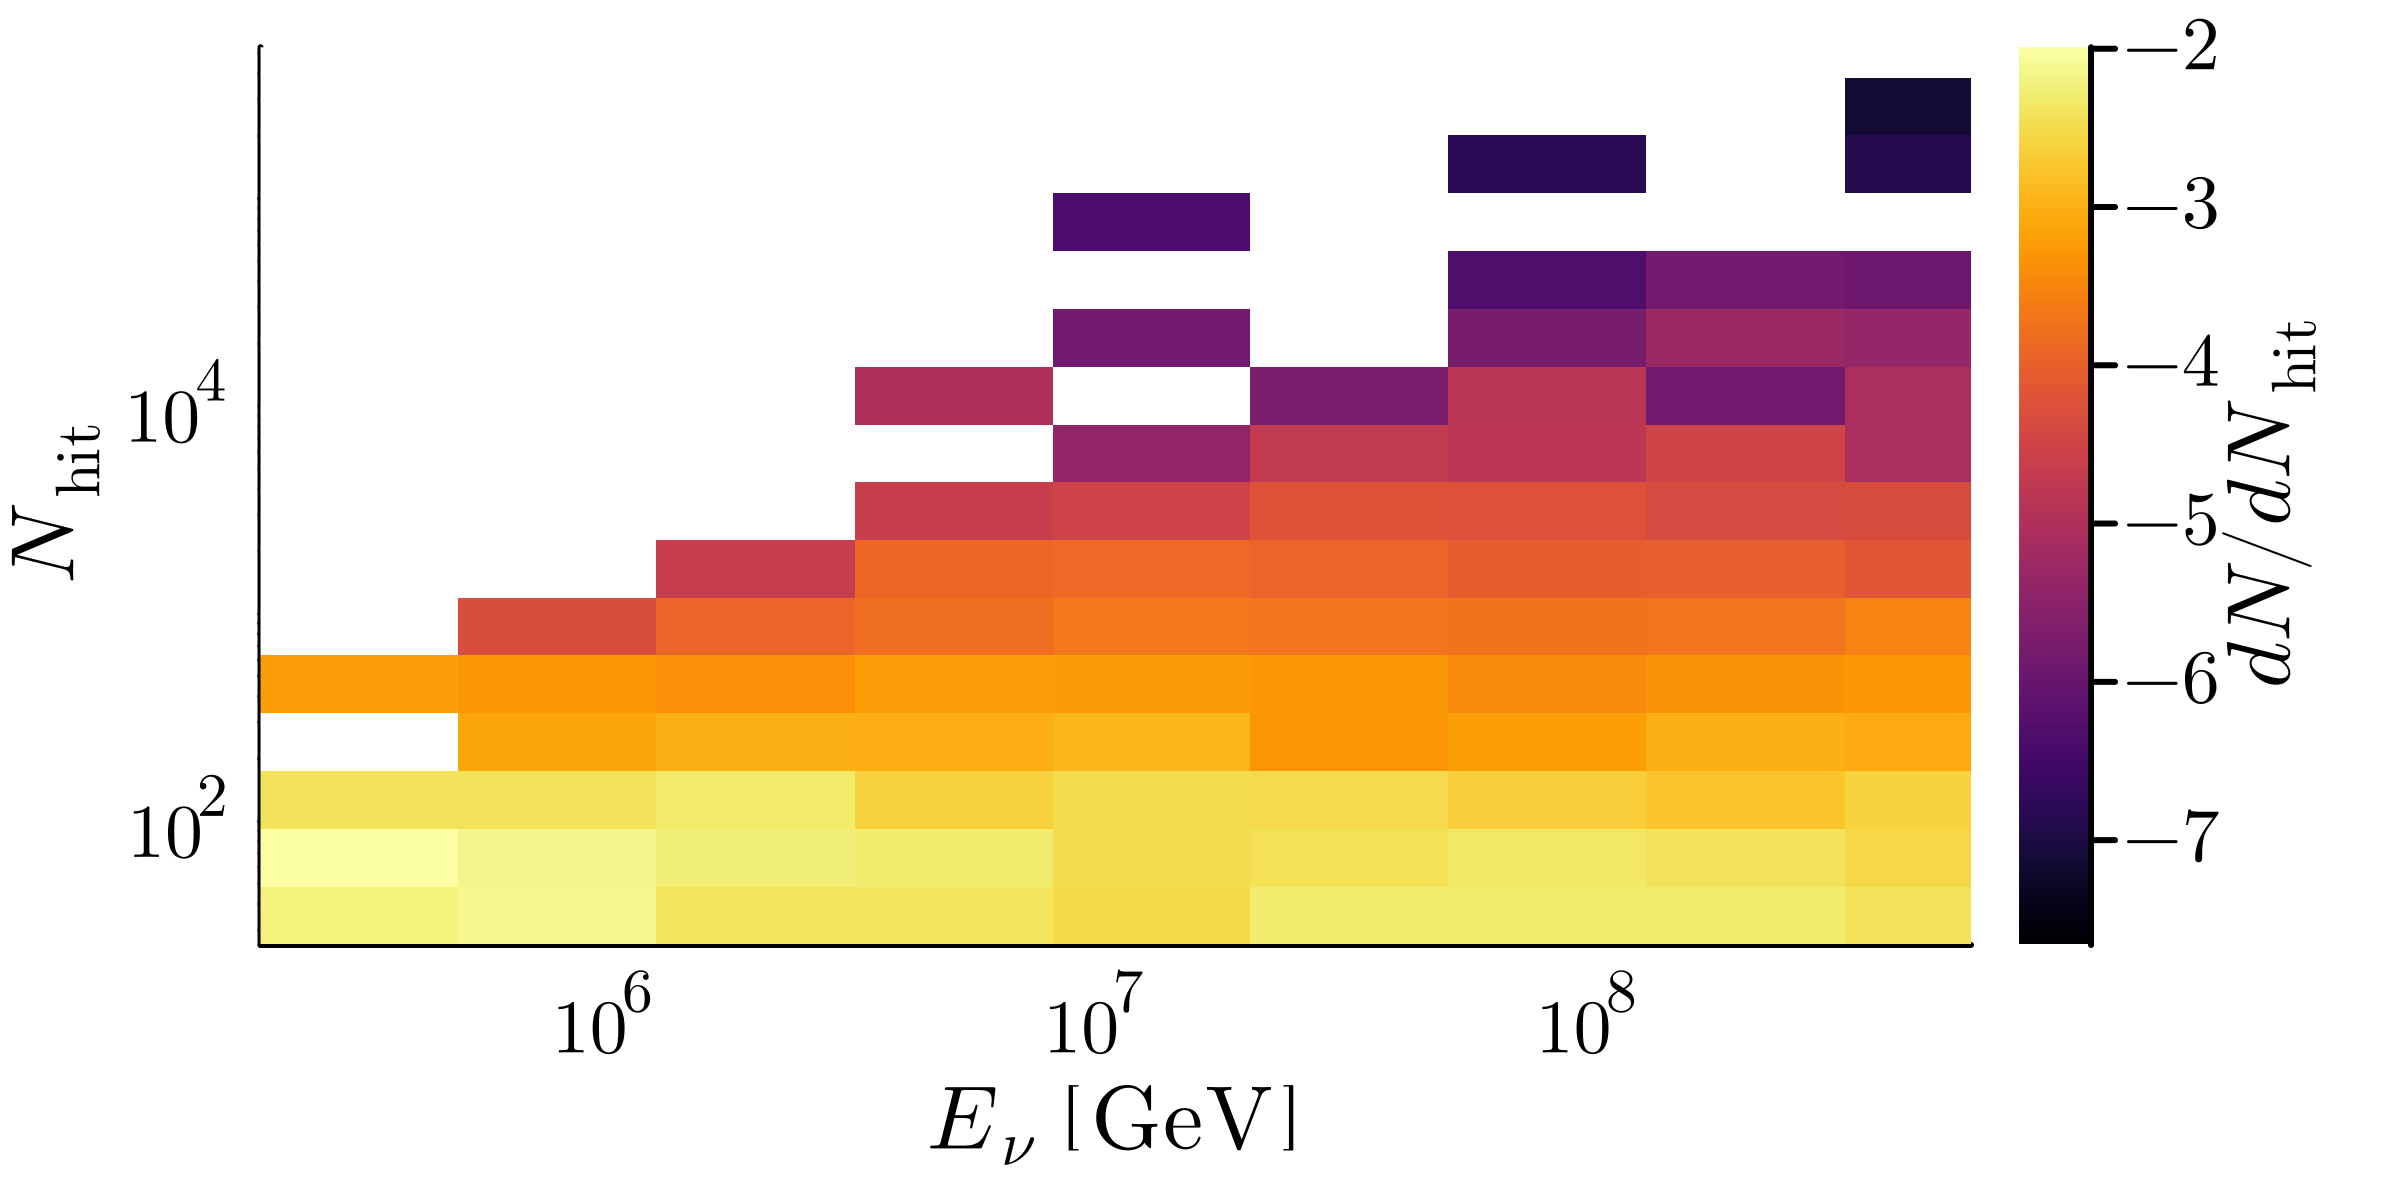

In [107]:
plt = plot(
    xscale=:log,
    yscale=:log,
    rightmargin=2mm,
    bottommargin=2mm,
    xlabel=L"E_{\nu}~\left[\mathrm{GeV}\right]",
    ylabel=L"N_{\mathrm{hit}}",
    colorbartitle=L"dN/dN_{\mathrm{hit}}"
)

heatmap!(
    plt,
    energy_cents ./ units.GeV,
    hit_cents,
    # log.(10, transpose(out./ sum(out, dims=2)))
    log.(10, transpose(out./ sum(out, dims=2)) ./ hit_widths)
    # transpose(out ./ sum(out, dims=2))
)
display(plt)

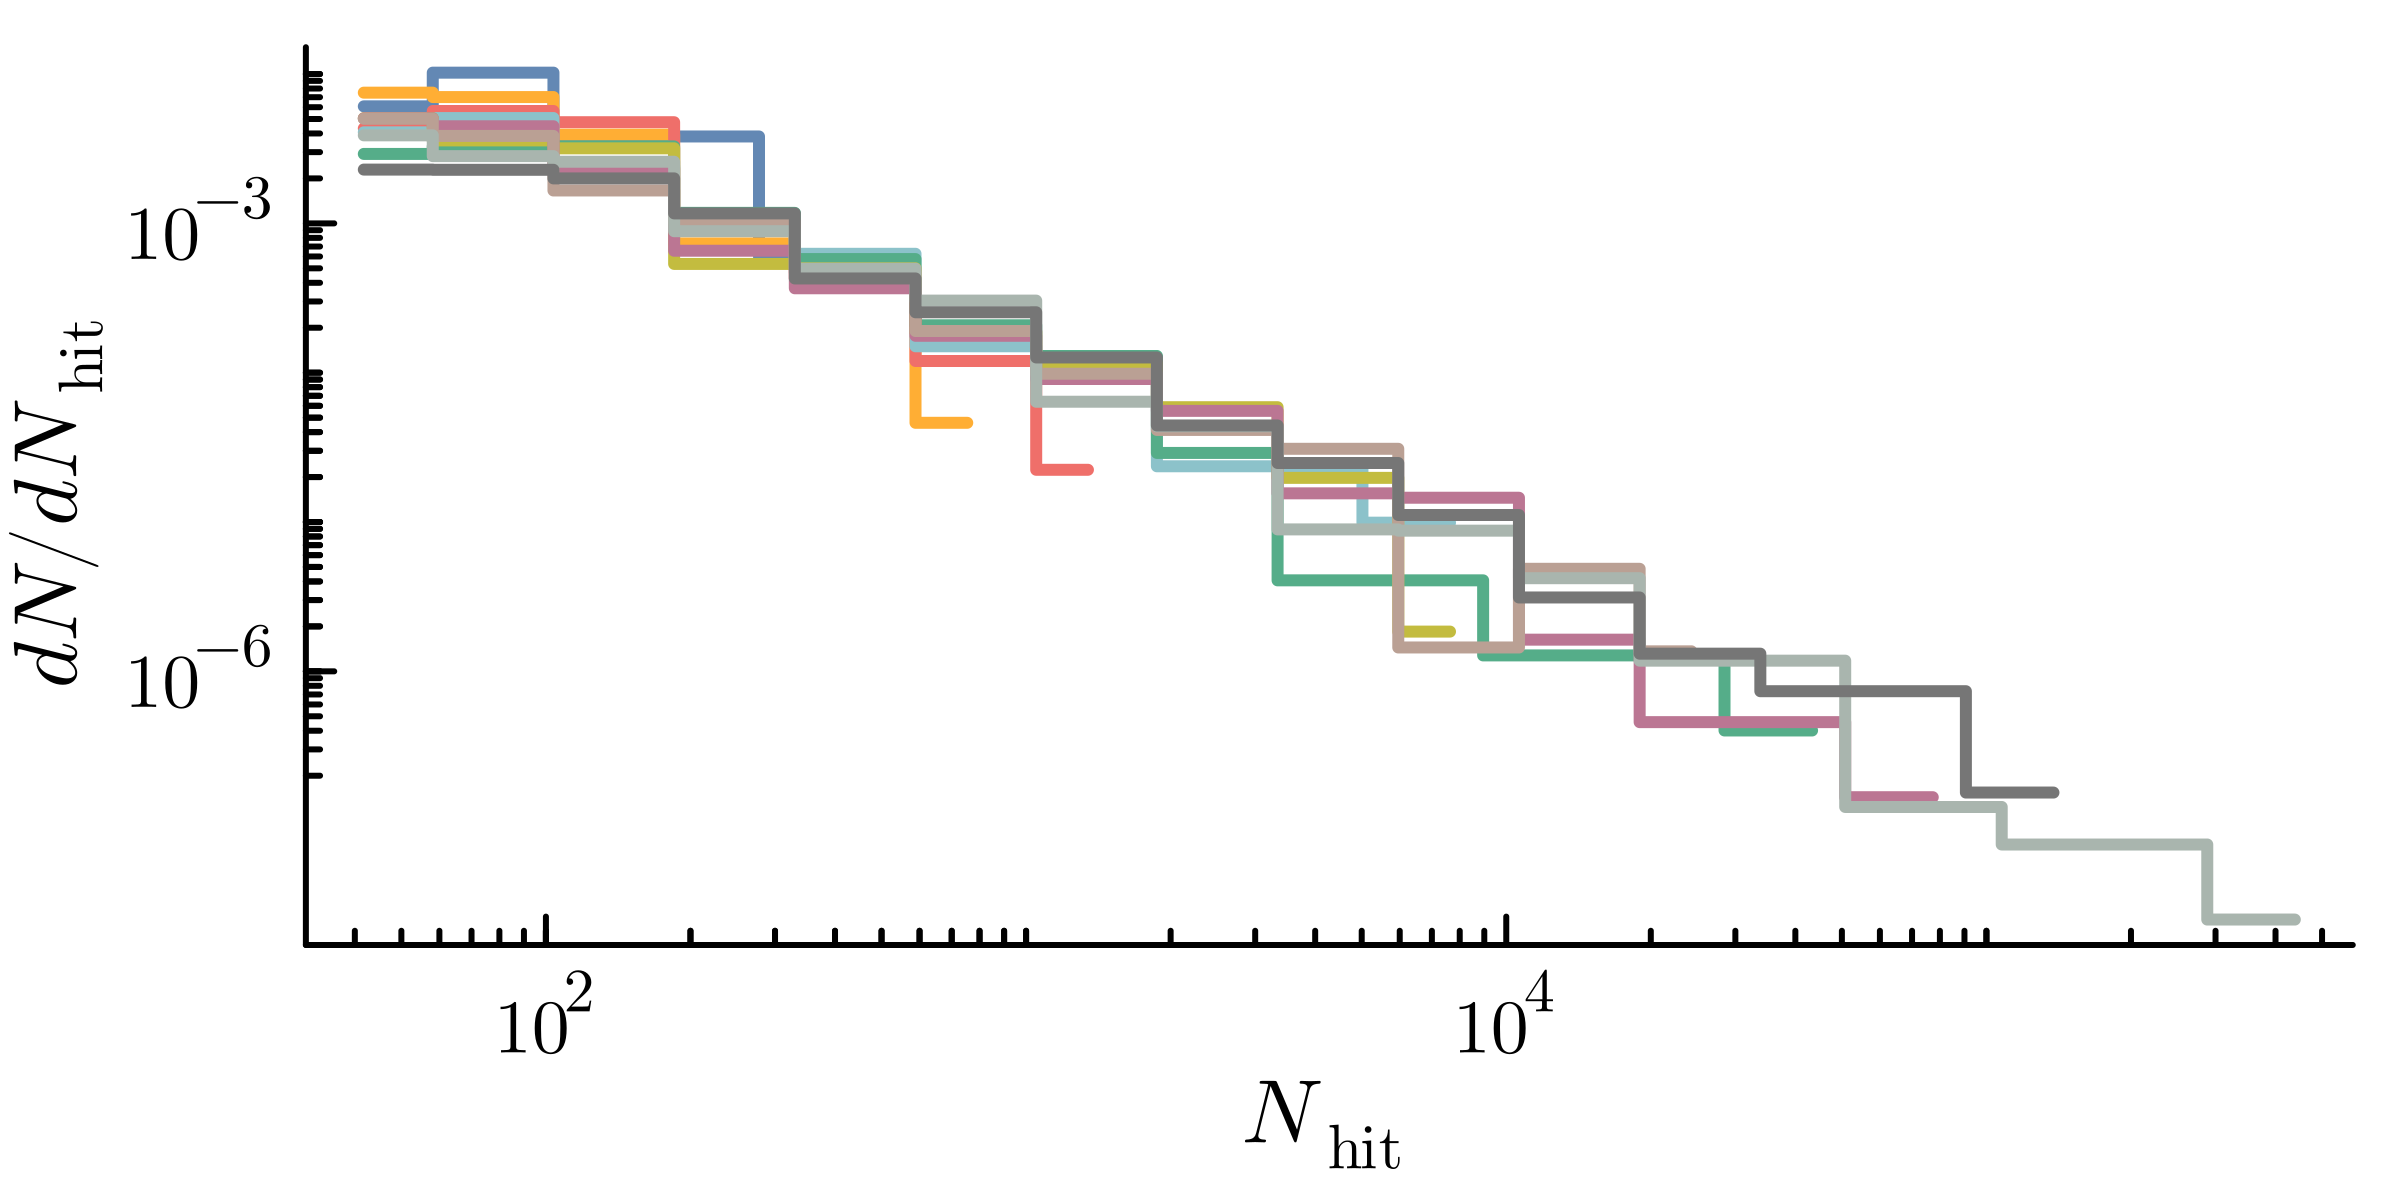

In [129]:
plt = plot(
    xscale=:log,
    yscale=:log,
    xlabel=L"N_{\mathrm{hit}}",
    ylabel=L"dN/dN_{\mathrm{hit}}",
    bottommargin=2mm
)

for idx in 1:size(out)[1]
    a = out[idx, :]
    a = a ./ sum(a) ./ hit_widths
    mask = a .> 0
    plot!(
        plt,
        hit_cents[mask], 
        a[mask], 
        linetype=:stepmid,
        # label=energy_cents[idx] / units.GeV
    )
end
display(plt)

In [159]:
gp = upgoing_event_dicts["20231231/1000_150"]
sim = upgoing_sim

event_numbers = Int[]

for key in keys(gp)
    if ~has_triggered(gp[key])
        continue
    end
    event_number = parse(Int, key)
    decay_point = sim["proposal_events"][event_number].propped_state.position
    dir = sim["proposal_events"][event_number].propped_state.direction
    tr = Tambo.Track(decay_point, dir, geo.box)
    _, int_point, _ = intersect(tr, plane)
    # println(int_point)
    dist = sqrt(sum((int_point .- decay_point) .^ 2))
    if dist < 2.75units.km || 3.25units.km < dist
        continue
    end
    println(dist / units.km)
    push!(event_numbers, event_number)
end
event_numbers

3.1385382070129153
2.766559000681181
2.9308591245325344
2.770907721059412
3.111565658611915
2.8620107381159245
2.943835322647301
3.1375613273129455
2.8016548757547173
3.131331623889006
3.097327710166181
2.9968684733450837
2.9789967073904426
2.881610477194913
3.1088490188466107


15-element Vector{Int64}:
 36786
   147
 59462
  1005
 14214
 33815
 50214
 33847
  7116
 60488
 12136
 16438
 43383
 47204
 49706

In [164]:
sim["injected_events"]["final_state"][event_numbers]["energy"]

15-element Vector{Float64}:
 3.914688798932535e14
 1.927865884729408e17
 1.0340774836025688e17
 4.094792821461542e17
 4.257465268861274e14
 1.4954033410689162e16
 1.7307599324199842e16
 1.5836612881556125e17
 6.678208438633428e17
 1.8582182925380442e15
 2.7469132463433197e17
 1.2311618365528835e17
 3.12329193924918e15
 1.1713448791237674e16
 4.060059765568273e16

In [17]:
upgoing_sim["config"][:θmax]

1.5707963267948966

In [21]:
edges = 10 .^ (log(10, 3e14):0.25:18)
cents = (edges[1:end-1] + edges[2:end]) / 2
widths = edges[2:end] - edges[1:end-1]

sims = [
    upgoing_sim,
    downgoing_sim,
    lowe_sim
]
gps = [
    upgoing_event_dicts["20231231/1000_150"],
    downgoing_event_dicts["20240201/1000_150"],
    lowe_event_dicts["20240202/1000_150"]
] 

out = zeros(length(cents))

θmin = Inf
ϕmin = Inf
θmax = -Inf
ϕmax = -Inf

for (idx, (gp, sim)) in enumerate(zip(gps, sims))
    using Random
    Random.seed!(343)

    triggered_event_numbers = Int[]

    for key in keys(gp)
        # Extremely jank to remove events that don't cross rock
        if idx==2 && ~(parse(Int, key) in findall(did_cross_rock))
            continue
        end
        if ~has_triggered(gp[key])
            continue
        end
        push!(triggered_event_numbers, parse(Int, key))
        
        dir = sim["injected_events"][parse(Int, key)].initial_state.direction
        θmin = minimum([dir.θ, θmin])
        ϕmin = minimum([dir.ϕ, ϕmin])
        θmax = maximum([dir.θ, θmax])
        ϕmax = maximum([dir.ϕ, ϕmax])
        
    end

end

In [24]:
(cos(θmin) - cos(θmax)) * (ϕmax - ϕmin)

2.2019781473609004

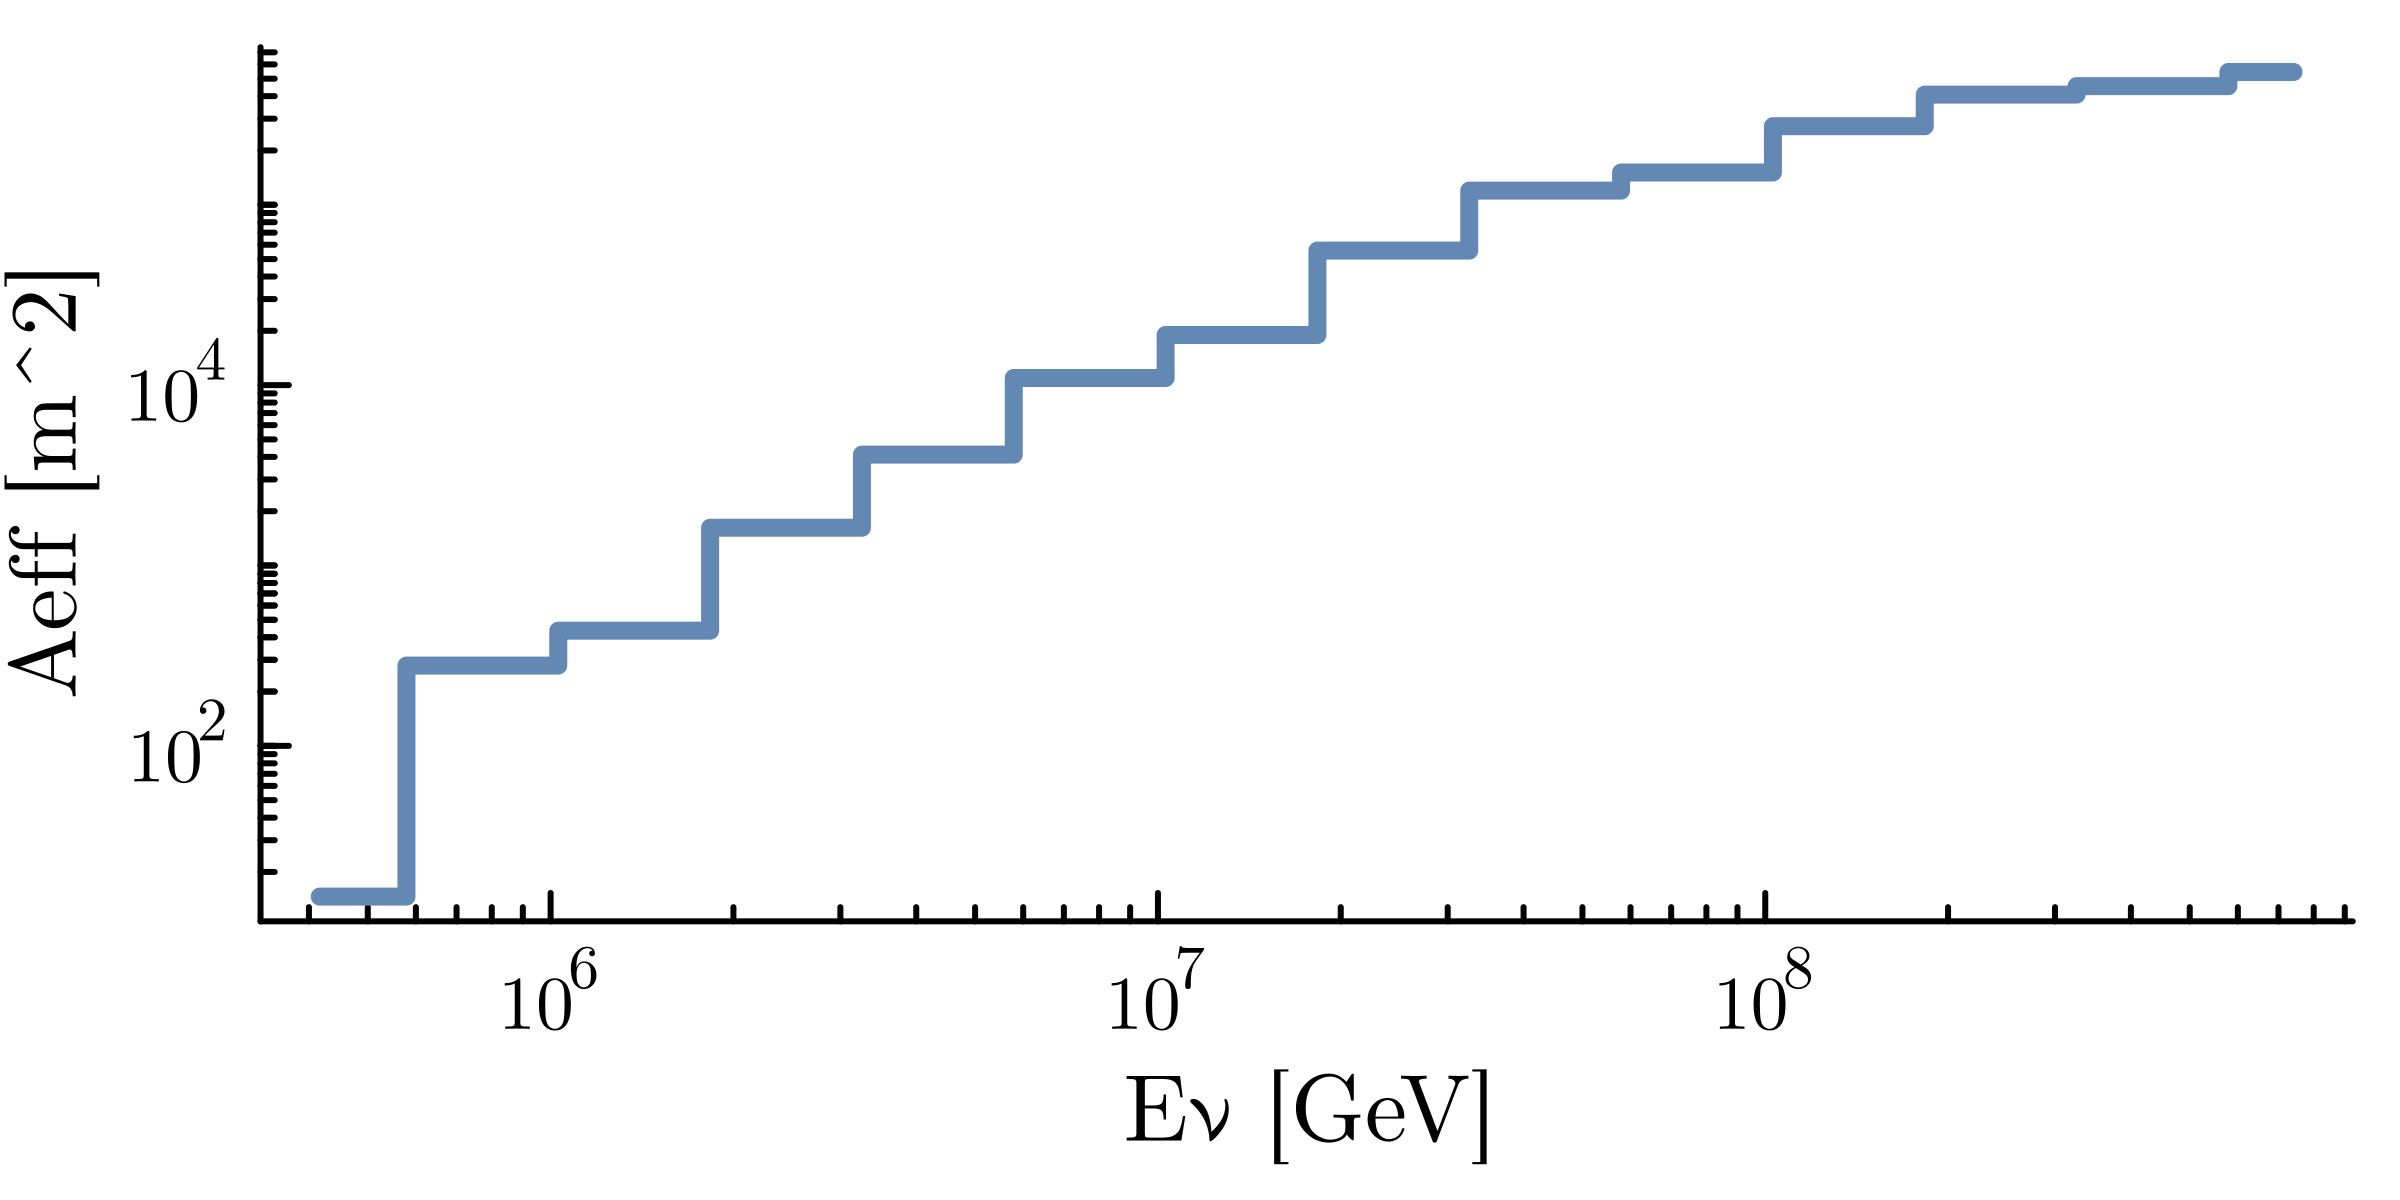

In [34]:
edges = 10 .^ (log(10, 3e14):0.25:18)
cents = (edges[1:end-1] + edges[2:end]) / 2
widths = edges[2:end] - edges[1:end-1]

sims = [
    upgoing_sim,
    downgoing_sim,
    lowe_sim
]
gps = [
    upgoing_event_dicts["20231231/1000_150"],
    downgoing_event_dicts["20240201/1000_150"],
    lowe_event_dicts["20240202/1000_150"]
] 

out = zeros(length(cents))

ΔΩ = (cos(θmin) - cos(θmax)) * (ϕmax - ϕmin)

for (idx, (gp, sim)) in enumerate(zip(gps, sims))
    using Random
    Random.seed!(343)

    triggered_event_numbers = Int[]

    for key in keys(gp)
        # Extremely jank to remove events that don't cross rock
        if idx==2 && ~(parse(Int, key) in findall(did_cross_rock))
            continue
        end
        if ~has_triggered(gp[key])
            continue
        end
        push!(triggered_event_numbers, parse(Int, key))
        
    end
    
    injected_events = sim["injected_events"]
    triggered_events = injected_events[triggered_event_numbers];

    triggered_weights = Tambo.oneweight.(
        triggered_events,
        Ref(injector.xs),
        Ref(injector.xs),
        Ref(injector.powerlaw),
        Ref(injector.anglesampler),
        Ref(injector.injectionvolume),
        Ref(geo)
    ) / maximum(triggered_event_numbers)
    
    h = fit(
        Histogram,
        triggered_events["initial_state"]["energy"],
        Weights(triggered_weights),
        edges
    )
    
    out .+= h.weights ./ widths ./ ΔΩ
end
plt = plot(
    cents ./ units.GeV,
    out .* (22_000 / length(modules)) / units.m^2,
    linetype=:stepmid, lw=3,
    xscale=:log10,
    yscale=:log10,
    xlabel="Eν [GeV]",
    ylabel="Aeff [m^2]",
    bottommargin=3mm,
)

display(plt)

In [36]:
CSV.File("../")

[4.167419115058369e14, 7.410835605310925e14, 1.3178536368107755e15, 2.343511987785515e15, 4.167419115058369e15, 7.410835605310926e15, 1.317853636810779e16, 2.3435119877855244e16, 4.167419115058386e16, 7.410835605310955e16, 1.3178536368107811e17, 2.3435119877855245e17, 4.167419115058386e17, 7.410835605310956e17]


In [38]:
println(out.* (22_000 / length(modules)))

[3.7487906588945906e14, 7.157874704876956e15, 1.1171710673062234e16, 4.157390439419208e16, 1.0574667638600392e17, 2.8133374665457165e17, 4.8706048220581875e17, 1.4305098647937477e18, 3.07580824077941e18, 3.8746388874890563e18, 6.997841927298492e18, 1.0474857532157921e19, 1.1679066571702622e19, 1.3985795606407016e19]
